In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Set boundary conditions and use to intialize snapshot arrays
def u_bcs(u):
    ghost_r = np.zeros((1, nx))
    ghost_c = np.zeros((ny-2, 1))
    u = np.append(ghost_c, u, axis=1)
    u = np.append(u, ghost_c, axis=1)
    u = np.append(ghost_r, u, axis=0)
    u = np.append(u, ghost_r, axis=0)

    u[0, :] = lid_speed
    return u

def v_bcs(v):
    ghost_r = np.zeros((1, nx))
    ghost_c = np.zeros((ny-2, 1))
    v = np.append(ghost_c, v, axis=1)
    v = np.append(v, ghost_c, axis=1)
    v = np.append(ghost_r, v, axis=0)
    v = np.append(v, ghost_r, axis=0)

    v[:, 0] = 0
    return v

def p_bcs(p, initialize=False):
    if initialize:
        ghost_r = np.zeros((1, nx))
        ghost_c = np.zeros((ny-2, 1))
        p = np.append(ghost_c, p, axis=1)
        p = np.append(p, ghost_c, axis=1)
        p = np.append(ghost_r, p, axis=0)
        p = np.append(p, ghost_r, axis=0)

        p[:, 0] = p[:, 1]  # dp/dx = 0 @ x = 0
        p[:, -1] = p[:, -2]  # dp/dx = 0 @ x = L
        p[-1, :] = p[-2, :]  # dp/dy = 0 @ y = 0
        p[0, :] = 0  # p = 0 at y = L

    else:
        p[:, 0] = p[:, 1]  # dp/dx = 0 @ x = 0
        p[:, -1] = p[:, -2]  # dp/dx = 0 @ x = L
        p[-1, :] = p[-2, :]  # dp/dy = 0 @ y = 0
        p[0, :] = 0  # p = 0 at y = L
        
    return p
 

In [4]:
def Re_calc(nu, u, L):
    return L*u/nu

In [5]:
def CFL(dx, dt, u):
    return u*dt/dx

In [6]:
def Pe_calc(u, L, mu):
    return u*L/mu

In [7]:
# Advance u velocity without considering pressure term
def frac_advance_u(un, vn):
    u_frac = np.array(un, copy=True)
    u_frac = un[1:-1, 1:-1] + dt*(nu*((un[2:, 1:-1] - 2*un[1:-1, 1:-1] + un[0:-2, 1:-1])/(dy**2) + (un[1:-1, 2:] - 2*un[1:-1, 1:-1] + un[1:-1, 0:-2])/(dx**2)) \
     - un[1:-1, 1:-1]*(un[1:-1, 1:-1] - un[1:-1, 0:-2])/dx - vn[1:-1, 1:-1]*(un[1:-1, 1:-1] - un[0:-2, 1:-1])/dy)

    return u_frac

In [8]:
# Advance y velocity without considering pressure term
def frac_advance_v(vn, un):
    v_frac = np.array(vn, copy=True)
    v_frac = vn[1:-1, 1:-1] + dt*(nu*((vn[2:, 1:-1] - 2*vn[1:-1, 1:-1] + vn[0:-2, 1:-1])/(dy**2) + (vn[1:-1, 2:] - 2*vn[1:-1, 1:-1] + vn[1:-1, 0:-2])/(dx**2)) \
    - un[1:-1, 1:-1]*(vn[1:-1, 1:-1] - vn[1:-1, 0:-2])/dx - vn[1:-1, 1:-1]*(vn[1:-1, 1:-1] - vn[0:-2, 1:-1])/dy)
    return v_frac

In [9]:
def b_build(un, vn):
    b = 1 / dt * ((un[1:-1, 2:] - un[1:-1, 0:-2]) / (2 * dx) + (vn[2:, 1:-1] - vn[0:-2, 1:-1]) / (2 * dy)) + ((un[1:-1, 2:] - un[1:-1, 0:-2])/dx)**2 + 2*((un[1:-1, 1:-1] - un[0:-2, 1:-1])/dy)*((vn[1:-1, 1:-1] - vn[1:-1, 0:-2])/dx) + ((vn[1:-1, 1:-1] - vn[0:-2, 1:-1])/dy)**2

    return rho*(dx**2)*(dy**2)*b

In [10]:
def poisson_eqn(p, un, vn, b_build, it):
    b = b_build(un, vn)
    for i in range(it):
        p_nxt = np.array(p, copy=True)
        p_nxt[1:-1, 1:-1] = (1/2/(dy**2 + dx**2))*((dy**2)*(p[2:, 1:-1] + p[0:-2, 1:-1]) + (dx**2)*(p[1:-1, 2:] + p[1:-1, 0:-2]) - b)
        p = p_nxt
        p = p_bcs(p)
    return p
    

In [11]:
# Define the geometry of the box 
L = 0.005  # m
H = 0.005 # m

# Define the spatial spacing 
nx = 256
ny = 256
dx = L/nx  # mm
dy = H/ny  # mm

# Define temporal parameters
dt = 5e-6  # s
t_0 = 0  # s
t_f = 0.02  # s
nt = int((t_f - t_0)/dt)

# Define lid speed in m/s
lid_speed = 1

In [12]:
# Define rheology
mu = 1e-5 # kg/m/s
rho = 1  # kg/m^3
nu = mu/rho  # m^2 / s

In [13]:
print(f"Courant Number {CFL(dx, dt, lid_speed)}")
print(f"Reynolds number {Re_calc(nu, lid_speed, L)}")
print(f"Peclet number {Pe_calc(lid_speed, L, mu)}")
print(nt)

Courant Number 0.256
Reynolds number 499.99999999999994
Peclet number 499.99999999999994
3999


In [14]:
# Initialize velocity and pressure arrays
u = np.zeros((nx-2, ny-2))
v = np.zeros((nx-2, ny-2))
p = np.zeros((nx-2, ny-2))

In [15]:
#  Set Initial conditions
un = u_bcs(u)
vn = v_bcs(v)
p = p_bcs(p, initialize=True)

In [16]:
for t in range(nt):
    p_nxt = poisson_eqn(p, un, vn, b_build, it=50)

    u = frac_advance_u(un, vn) - (dt/rho)*(p_nxt[1:-1, 2:] - p_nxt[1:-1, 0:-2])/2/dx
    v = frac_advance_v(vn, un) - (dt/rho)*(p_nxt[2:, 1:-1] - p_nxt[0:-2, 1:-1])/2/dy

    un = u_bcs(u)
    vn = v_bcs(v)
    p = p_nxt

    if t % 100 == 0:
        print(f"Iteration: {t}")


Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Iteration: 1000
Iteration: 1100


KeyboardInterrupt: 

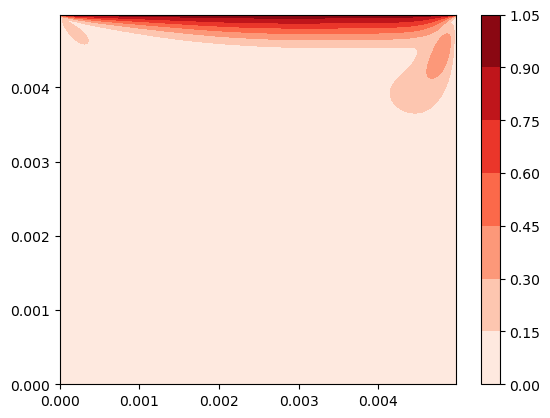

In [17]:
plt.figure()
plt.contourf(np.arange(0, L, dx), np.arange(0, H, dy), np.flipud(np.sqrt((un**2 + vn**2))), cmap='Reds')
# plt.contourf(np.arange(0, L, dx), np.arange(0, H, dy), u)
# plt.plot([0.001875, 0.001875], [0, 0.00304688], c='black')
# plt.plot([0.001875, 0.003125], [0.00304688, 0.00304688], c='black')
# plt.plot([0.003125, 0.003125], [0, 0.00304688], c='black')
plt.colorbar()
plt.show()

Text(0, 0.5, 'Y')

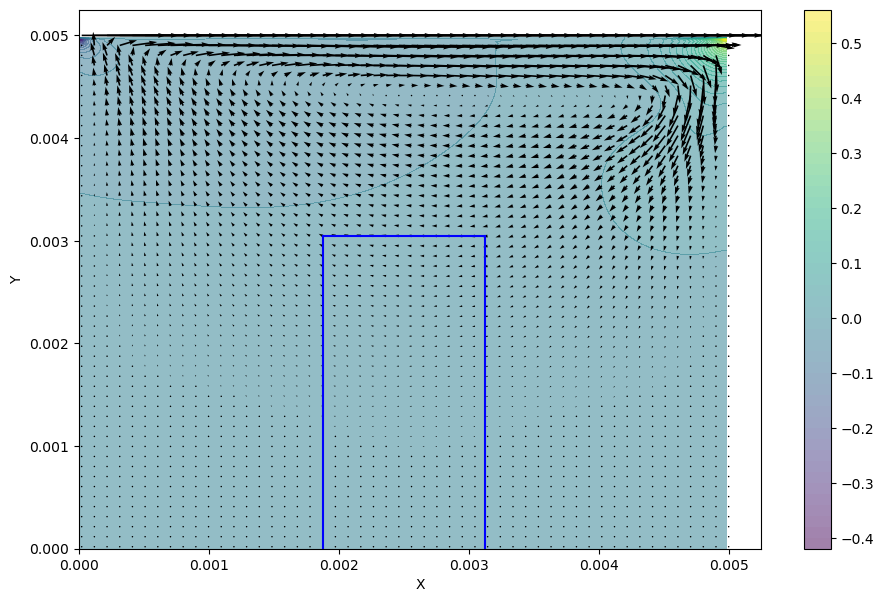

In [22]:
fig = plt.figure(figsize=(11,7), dpi=100)
X, Y = np.meshgrid(np.linspace(L, 0, nx+1), np.linspace(H, 0, ny+1))
skip = 5

plt.contourf(np.arange(0, L, dx), np.arange(0, H, dy), np.flipud(p), alpha=0.5, cmap='viridis', levels=50)  
plt.colorbar()
# plotting the pressure field outlines
# plt.contour(np.arange(0, L, dx), np.arange(0, H, dy), p, cmap='viridis')  
# plotting velocity field
plt.quiver(np.fliplr(X[::skip, ::skip]), Y[::skip, ::skip], un[::skip, ::skip], -1*vn[::skip, ::skip], )
plt.plot([0.001875, 0.001875], [0, 0.00304688], c='b')
plt.plot([0.001875, 0.003125], [0.00304688, 0.00304688], c='b')
plt.plot([0.003125, 0.003125], [0, 0.00304688], c='b')
plt.xlabel('X')
plt.ylabel('Y')